# **Klasifikasi 3 Varietas Beras**

# Mengambil *Dataset* dari *Github*

In [5]:
!apt-get install subversion > /dev/null

!svn export https://github.com/DwiWahyuEffendi/Klasifikasi-3-Varietas-Beras/trunk/data_nf/ > /dev/null  --force

Authentication realm: <https://github.com:443> GitHub
Password for 'root': ****************************************


-----------------------------------------------------------------------
ATTENTION!  Your password for authentication realm:

   <https://github.com:443> GitHub

can only be stored to disk unencrypted!  You are advised to configure
your system so that Subversion can store passwords encrypted, if
possible.  See the documentation for details.

You can avoid future appearances of this warning by setting the value
of the 'store-plaintext-passwords' option to either 'yes' or 'no' in
'/root/.subversion/servers'.
-----------------------------------------------------------------------
Store password unencrypted (yes/no)? y


## Persiapan

Program ini dibuat untuk membedakan 3 varietas beras yaitu :

1.   Varietas Beras Basmathi
2.   Varietas Beras IR 64
3.   Varietas Beras Ketan

## Memasukan Fungsi *Library*

In [6]:
from __future__ import absolute_import, division, print_function, unicode_literals

try:
  # The %tensorflow_version magic only works in colab.
  %tensorflow_version 2.x
except Exception:
  pass
import numpy as np 
import math, os, sys
import itertools
import random

import matplotlib.pyplot as plt
plt.style.use('default')
from scipy import ndimage

from skimage import measure, morphology
from skimage.io import imsave, imread
from skimage.filters import threshold_otsu
from skimage.transform import resize

import tensorflow as tf
from sklearn import svm, datasets
from sklearn.metrics import confusion_matrix
import pandas as pd

## Mengimpor Dataset

In [7]:
#Perintah di bawah ini untuk melihat list bagian dari file yang sudah diunduh dari Github
!ls data_nf/image
!ls data_nf/image/train
!ls data_nf/image/train/Basmathi
!ls data_nf/image/train/IR64
!ls data_nf/image/train/Ketan

test  train
Basmathi  IR64	Ketan
B_nf001.jpg  B_nf014.jpg  B_nf027.jpg  B_nf040.jpg  B_nf053.jpg  B_nf066.jpg
B_nf002.jpg  B_nf015.jpg  B_nf028.jpg  B_nf041.jpg  B_nf054.jpg  B_nf067.jpg
B_nf003.jpg  B_nf016.jpg  B_nf029.jpg  B_nf042.jpg  B_nf055.jpg  B_nf068.jpg
B_nf004.jpg  B_nf017.jpg  B_nf030.jpg  B_nf043.jpg  B_nf056.jpg  B_nf069.jpg
B_nf005.jpg  B_nf018.jpg  B_nf031.jpg  B_nf044.jpg  B_nf057.jpg  B_nf070.jpg
B_nf006.jpg  B_nf019.jpg  B_nf032.jpg  B_nf045.jpg  B_nf058.jpg  B_nf071.jpg
B_nf007.jpg  B_nf020.jpg  B_nf033.jpg  B_nf046.jpg  B_nf059.jpg  B_nf072.jpg
B_nf008.jpg  B_nf021.jpg  B_nf034.jpg  B_nf047.jpg  B_nf060.jpg  B_nf073.jpg
B_nf009.jpg  B_nf022.jpg  B_nf035.jpg  B_nf048.jpg  B_nf061.jpg  B_nf074.jpg
B_nf010.jpg  B_nf023.jpg  B_nf036.jpg  B_nf049.jpg  B_nf062.jpg  B_nf075.jpg
B_nf011.jpg  B_nf024.jpg  B_nf037.jpg  B_nf050.jpg  B_nf063.jpg
B_nf012.jpg  B_nf025.jpg  B_nf038.jpg  B_nf051.jpg  B_nf064.jpg
B_nf013.jpg  B_nf026.jpg  B_nf039.jpg  B_nf052.jpg  B_nf065.jpg
I_nf0

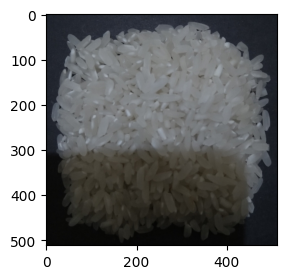

In [8]:
#Perintah untuk memvisualisasikan satu gambar dari data train
image = imread("data_nf/image/train/IR64/I_nf017.jpg")
plt.figure(figsize=(3,3))
plt.imshow(image)

In [9]:
#Memuat semua gambar ke memori untuk pertama kali

#Memuat dataset pelatihan
IMAGE_SIZE = 224
BATCH_SIZE = 128
base_dir = os.path.join('data_nf/image/train')

datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255, 
    validation_split=0.2)

train_generator = datagen.flow_from_directory(
    base_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE, 
    subset='training')

val_generator = datagen.flow_from_directory(
    base_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE, 
    subset='validation')

#Memuat dataset pengujian
X_test = []
y_test = []
labels = ['Basmathi', 'IR64', 'Ketan']

for i,label in enumerate(labels):
    folder = os.path.join("data_nf/image/test",label)
    files = sorted(os.listdir(folder))
    files = [x for x in files if x.endswith(".jpg")]
    for k,file in enumerate(files):
        image_path = os.path.join(folder, file)
        
        image = imread(image_path)/255.
        image = resize(image,(224,224))
        X_test.append(image)
        category = os.path.split(folder)[-1]
        y_test.append(i)

X_test = np.array(X_test)
y_test = np.array(y_test)

#Menampilkan bentuk dari masing-masing dataset
for image_batch, label_batch in train_generator:
  break
print("Bentuk array dari dataset train (pelatihan) adalah:", image_batch.shape,label_batch.shape)
for image_batch, label_batch in val_generator:
  break
print("Bentuk array dari dataset validation (validasi) adalah:", image_batch.shape,label_batch.shape)
print("Bentuk array dari dataset test (pengujian) adalah:", X_test.shape,y_test.shape)

Found 180 images belonging to 3 classes.
Found 45 images belonging to 3 classes.
Bentuk array dari dataset train (pelatihan) adalah: (128, 224, 224, 3) (128, 3)
Bentuk array dari dataset validation (validasi) adalah: (45, 224, 224, 3) (45, 3)
Bentuk array dari dataset test (pengujian) adalah: (45, 224, 224, 3) (45,)


## Menyimpan Label

In [10]:
print (train_generator.class_indices)

labels_txt = '\n'.join(sorted(train_generator.class_indices.keys()))

with open('labels.txt', 'w') as f:
  f.write(labels_txt)

{'Basmathi': 0, 'IR64': 1, 'Ketan': 2}


In [11]:
!cat labels.txt

Basmathi
IR64
Ketan

# Membuat Model dari Jaringan CNN yang Sudah dipelajari Sebelumnya (*pre-trained convnets*)

In [12]:
IMG_SHAPE = (224, 224, 3)
# Membuat model dasar (base model) dari pre-trained model VGG-16Net
base_model = tf.keras.applications.VGG16(input_shape=IMG_SHAPE,
                                              include_top=False, 
                                              weights='imagenet')

58900480/58889256 [==============================] - 0s 0us/step


## *Feature Extraction*

In [13]:
base_model.trainable = False
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

# Mengelompokkan Klasifikasi Tiga Jenis Beras dengan *Deep learning* (*Convolutional Neural Network*)

In [14]:
import keras
from keras import backend as K
from keras.models import Sequential
from keras import layers
from keras.utils.np_utils import to_categorical

from sklearn.model_selection import train_test_split

## Mempersiapkan Data Masukkan Pengujian

In [15]:
y_test2 = to_categorical(y_test)
X_test3, y_test3 = (X_test, y_test2)

## Pembuatan Model (Menambah Model)

In [16]:
model = tf.keras.Sequential([
    base_model,    
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    #tf.keras.layers.Dropout(0.2),
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(3, activation='softmax')
])

model.compile("adam",loss="categorical_crossentropy",metrics=["acc"])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 conv2d (Conv2D)             (None, 5, 5, 32)          147488    
                                                                 
 global_average_pooling2d (G  (None, 32)               0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 3)                 99        
                                                                 
Total params: 14,862,275
Trainable params: 147,587
Non-trainable params: 14,714,688
_________________________________________________________________


## Pelatihan

In [17]:
#Menyimpan file model bobot yang terbaik selama pelatihan (dalam format keras)
history = model.fit_generator(train_generator, 
                    epochs=100, 
                    validation_data=val_generator)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  after removing the cwd from sys.path.


Epoch 1/100
2/2 [==============================] - 71s 46s/step - loss: 1.1545 - acc: 0.3111 - val_loss: 0.9600 - val_acc: 0.4222
Epoch 2/100
2/2 [==============================] - 3s 2s/step - loss: 0.8819 - acc: 0.6722 - val_loss: 0.9777 - val_acc: 0.3333
Epoch 3/100
2/2 [==============================] - 3s 2s/step - loss: 0.7824 - acc: 0.7111 - val_loss: 0.8443 - val_acc: 0.4889
Epoch 4/100
2/2 [==============================] - 3s 2s/step - loss: 0.6359 - acc: 0.8500 - val_loss: 0.7132 - val_acc: 0.6222
Epoch 5/100
2/2 [==============================] - 3s 2s/step - loss: 0.5536 - acc: 0.8556 - val_loss: 0.6069 - val_acc: 0.6889
Epoch 6/100
2/2 [==============================] - 3s 1s/step - loss: 0.5056 - acc: 0.8889 - val_loss: 0.5823 - val_acc: 0.7333
Epoch 7/100
2/2 [==============================] - 3s 1s/step - loss: 0.4349 - acc: 0.9000 - val_loss: 0.6237 - val_acc: 0.7111
Epoch 8/100
2/2 [==============================] - 3s 1s/step - loss: 0.3943 - acc: 0.9056 - val_loss:

## Menggambarkan Hasil Pelatihan

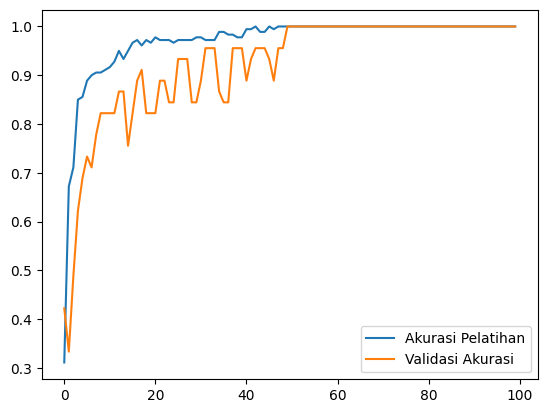

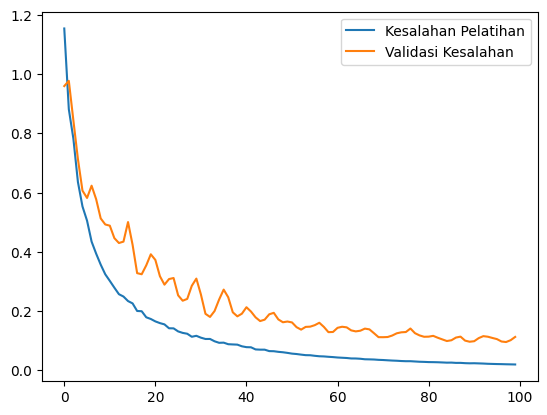

In [18]:
plt.plot(history.history["acc"],label="Akurasi Pelatihan")
plt.plot(history.history["val_acc"],label="Validasi Akurasi")
plt.legend()
plt.show()

plt.plot(history.history["loss"],label="Kesalahan Pelatihan")
plt.plot(history.history["val_loss"],label="Validasi Kesalahan")
plt.legend()
plt.show()

In [19]:
print('Number of trainable variables = {}'.format(len(model.trainable_variables)))

Number of trainable variables = 4


## Menggunakan Model

In [20]:
print(train_generator)

In [21]:
#Prediksi Label Validasi dengan Pelatihan
n = random.randint(0, 36)
input_image = image_batch[n][np.newaxis,...]
print("Labelnya adalah: ", label_batch[n])

predictions = model.predict(input_image)
print("Prediksinya adalah",predictions[0])

Labelnya adalah:  [0. 1. 0.]
Prediksinya adalah [0.40609995 0.5892993  0.00460071]


## Evaluasi

In [22]:
#Memeriksa matriks model
print(model.metrics_names)
#Evaluasi data test
print(model.evaluate(x= X_test3, y = y_test3)) 

['loss', 'acc']
2/2 [==============================] - 15s 4s/step - loss: 0.0649 - acc: 1.0000
[0.06488826870918274, 1.0]


In [23]:
#Menampilkan matriks yang benar dan matriks hasil prediksi

#Label yang benar
y_true = np.argmax(y_test2,axis=1)

#Label prediksi
Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print(y_true)
print(y_pred)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2]


## Prediksi Gambar Individual

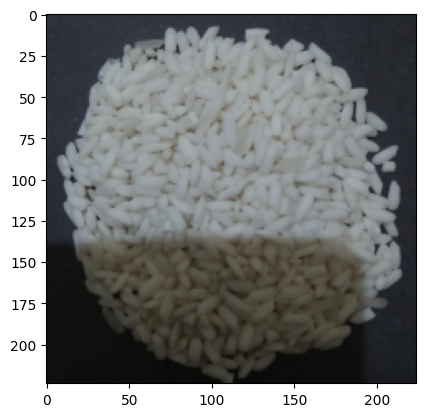

Label yang benar adalah: 2 : Ketan
Nilai yang diprediksi adalah: [2.0051464e-06 2.9809303e-03 9.9701703e-01]
Label yang diprediksi adalah: 2 : Ketan
Prediksi benar


In [24]:
n = random.randint(0, 34) #Jangan melampaui (nilai dari gambar test - 1)

plt.imshow(X_test[n])
plt.show()

true_label = np.argmax(y_test2,axis=1)[n]
print("Label yang benar adalah:",true_label,":",labels[true_label])
prediction = model.predict(X_test[n][np.newaxis,...])[0]
print("Nilai yang diprediksi adalah:",prediction)
predicted_label = np.argmax(prediction)
print("Label yang diprediksi adalah:",predicted_label,":",labels[predicted_label])

if true_label == predicted_label:
    print("Prediksi benar")
else:
    print("Prediksi salah")

## *Confusion Matrix*

Normalized confusion matrix
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]


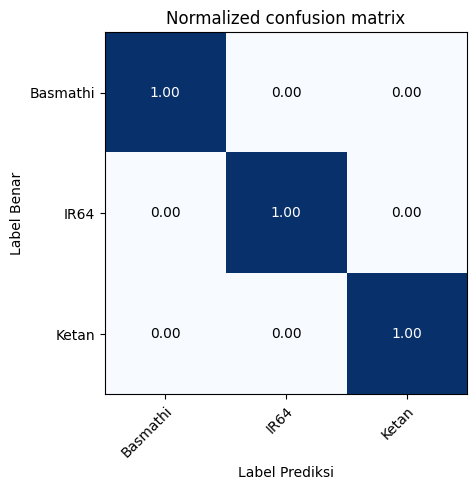

In [25]:
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=True,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    #classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots(figsize=(5,5))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    #ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='Label Benar',
           xlabel='Label Prediksi')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

plot_confusion_matrix(y_true, y_pred, classes=labels, normalize=True,
                      title='Normalized confusion matrix')